In [2]:
import sys
sys.path.append('/Users/balazstorok/SCIENCE/Projects/BMLLab/bart/python/')
import bart
import numpy as np

from pystan import StanModel
import pickle
#sm = StanModel('/Users/balazstorok/SCIENCE/Projects/BMLLab/bart/python/naive_model_3.stan')
#pickle.dump(sm,open('/Users/balazstorok/SCIENCE/Projects/BMLLab/bart/python/naive_model_3.pkl', 'wb'))
sm = pickle.load(open('/Users/balazstorok/SCIENCE/Projects/BMLLab/bart/python/naive_model_3.pkl','rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7fc499a0f151c7e1279a919e10353396 NOW.


In [ ]:
n = 20
i_max = 70
N_balloons = 30
rewards = np.array([2*i for i in range(i_max)])
chains = 2
iterations = 400
true_values = []

seed = 201
np.random.seed(seed = seed)

for i in range(n):
    m0 = np.exp(np.random.normal(3,1))
    true_values.append(dict(m0 = m0,
                            a0 = m0+np.exp(np.random.normal(3,1)),
                            gam = np.random.normal(0.9,0.2),
                            bet = np.random.normal(10,3),
                            i_max = i_max,
                            rewards = rewards,
                            p_pop = np.repeat(np.random.beta(2,20),i_max), 
                            n = N_balloons))

In [ ]:
import stan_plots as s_p
import importlib
importlib.reload(s_p)
base_params = dict()
for key, values in true_values[0].items():
    base_params[key] = [t[key] for t in true_values]
s_p.sample_plots(base_params, 1)

In [ ]:
from wurlitzer import sys_pipes
seed = 123

samples_list = []
players, experiments = [], []
def format_data_for_stan(data):
    dat = dict(N = len(data),
               pumps = [d['pumps']+1 for d in data],
               popped = [int(d['popped']) for d in data],
               )
    return(dat)

for params in true_values:
    players.append(bart.Model_3(a0 = params['a0'],
                                    m0 = params['m0'],
                                    beta = params['bet'],
                                    gamma = params['gam'],
                                    i_max = params['i_max'],
                                    naive = True
                                        ))
    experiments.append(bart.Experiment(player = players[-1], 
                                       p_pop = params['p_pop'], 
                                       rewards = params['rewards'],
                                       n = params['n']))
    wallet = experiments[-1].run_artificial()
    data = format_data_for_stan(experiments[-1].get_data())
    data['i_max'] = params['i_max']
    data['rewards'] = params['rewards']
    data['gamma_std'] = 2.0
    data['beta_std'] = 20.0
    data['a0_std'] = 400.0
    data['m0_std'] = 400.0
    
    with sys_pipes():
        iterations = 1000
        chains = 2
        fit = sm.sampling(data = data, 
                          iter = iterations,
                          chains = chains,
                          seed = seed)
        samples_list.append(fit.extract())

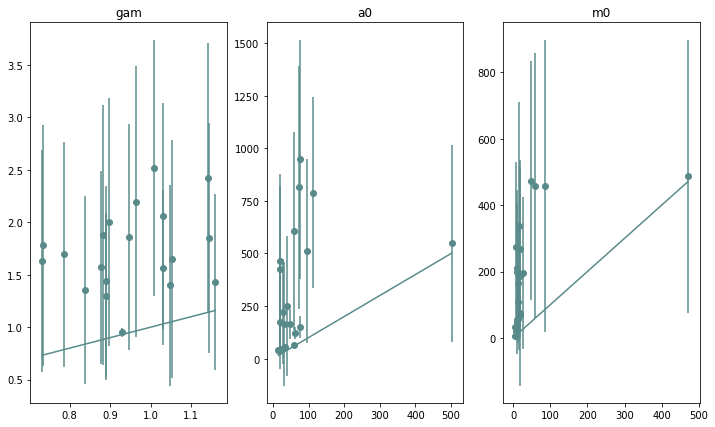

In [61]:
import matplotlib.pyplot as plt
def parameter_recovery_plot(samples_list):
    c = 0
    keys = ['gam','a0', 'm0','bet']
    fig, ax = plt.subplots(1, len(keys))
    for key in keys:

        ax[c].plot([min([t[key] for t in true_values]),
                      max([t[key] for t in true_values])],
                     [min([t[key] for t in true_values]),
                      max([t[key] for t in true_values])],
                   color = '#598a8a')
        ax[c].set_title(key)
        c += 1
    for i, samples in enumerate(samples_list):
        c = 0
        for key in keys:
            if not key=='lp__':
                ax[c].scatter(x = true_values[i][key], y = np.mean(samples[key]), color = '#598a8a')
                ax[c].errorbar(x = true_values[i][key], y = np.mean(samples[key]),
                               yerr = np.std(samples[key]),
                               color = '#598a8a')
                c += 1
    plt.show()
    
parameter_recovery_plot(samples_list)